In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

In [40]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, activation='relu'):
        super().__init__()
        layers = []

        if activation == 'relu':
            activation_function = nn.ReLU
        elif activation == 'tanh':
            activation_function = nn.Tanh
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_function())
        
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_function())
        
        # # Output layer
        # layers.append(nn.Linear(hidden_dim, 1))  # output size is 1
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class SelfMetaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, activation='relu'):
        super().__init__()
        self.model = FFNN(input_dim, hidden_dim, n_layers, activation)
        self.base_head = nn.Linear(hidden_dim, 1)
        self.meta_head = nn.Sequential(
            FFNN(1, hidden_dim, 1, activation),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        hidden = self.model(x)
        base_output = self.base_head(hidden)
        meta_output = self.meta_head(base_output)
        return base_output, meta_output


In [41]:
def train_to_convergence(model,
                         x_train,
                         y_train,
                         optimizer,
                         criterion,
                         loss_threshold=0.01,
                         max_epochs=1000):
    
    #pbar = tqdm(range(max_epochs), desc="Training", unit="epoch")
    #for epoch in pbar:
    y_train_meta = y_train.clone()
    for epoch in range(max_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs, meta_outputs = model(x_train)
        loss = criterion(outputs, y_train)
        meta_loss = criterion(meta_outputs, loss.detach()).mean()
        loss = loss.mean()


        if loss.item() < loss_threshold:
            break

        loss = loss + meta_loss

        loss.backward()
        optimizer.step()
        
        # Update progress bar description
        #bar.set_postfix(loss=loss.item())



In [42]:
def generate_sample(data_dict, unseen_rate=0.5):
    if len(data_dict) == 0 or random.random() < unseen_rate:
        # Generate new sample
        x = torch.randint(0, 2, (input_dim,), dtype=torch.float32)
        key = tuple(x.tolist())
        while key in data_dict:
            x = torch.randint(0, 2, (input_dim,), dtype=torch.float32)
            key = tuple(x.tolist())
        label = 0  # unseen
        data_dict[key] = label
    else:
        # Sample from seen set
        key = random.choice(list(data_dict.keys()))
        x = torch.tensor(key, dtype=torch.float32)
        label = 1  # seen
        data_dict[key] = label
    return x.unsqueeze(0), torch.tensor([label])

In [43]:
def dict_to_dataset(data_dict):
    
    x_list = list(data_dict.keys())
    y_list = list(data_dict.values())

    x_tensor = torch.tensor(x_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(1)      # shape (n_samples, 1)

    return x_tensor, y_tensor

In [ ]:
#
# Training Loop
#

# Hyperparameters
n_iterations = 1000
unseen_rate = 0.5
input_dim = 20
hidden_dim = 256
n_layers = 2
loss_threshold = 0.01 * 0 # stop training when loss falls below this
max_epochs = 3
learning_rate = 1e-3
weight_decay = 0
activation = 'relu'
criterion_name = 'mae'
if criterion_name == 'mse':
    criterion = nn.MSELoss(reduction='none')
elif criterion_name == 'mae':
    criterion = nn.L1Loss(reduction='none')
elif criterion_name == 'log_loss':
    criterion = nn.BCEWithLogitsLoss(reduction='none')

# Initialize model and optimizer (should it/they be reoptimized every time?)
model = SelfMetaModel(input_dim, hidden_dim, n_layers, activation)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
data_dict = {}

# Initialize record-keeping
labels_true = []
logits_pred = []
meta_logits_pred = []
probs_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Encounter new sample
    x, y = generate_sample(data_dict)
    labels_true.append(y.squeeze().item())

    # Collect prediction
    model.eval()
    with torch.no_grad():
        logits, meta_logits = model(x)
        logits_pred.append(logits[0].item())
        meta_logits_pred.append(meta_logits[0].item())

        if criterion_name == 'log_loss':
            probs = torch.sigmoid(logits)  # now in [0, 1]
            probs_pred.append(probs[0].item())
        else:
            probs_pred.append(logits_pred[-1])

    # Update model
    x_train, y_train = dict_to_dataset(data_dict)
    train_to_convergence(model, x_train, y_train, optimizer, criterion, loss_threshold=loss_threshold, max_epochs=max_epochs)
    

100%|██████████| 1000/1000 [00:04<00:00, 249.61it/s]


In [45]:
# Separate seen and unseen for plotting
seen_probs = []
unseen_probs = []
for label, prob in zip(labels_true, probs_pred):
    if label:
        seen_probs.append(prob)
    else:
        unseen_probs.append(prob)

seen_logits = []
unseen_logits = []
for label, logit in zip(labels_true, logits_pred):
    if label:
        seen_logits.append(logit)
    else:
        unseen_logits.append(logit)

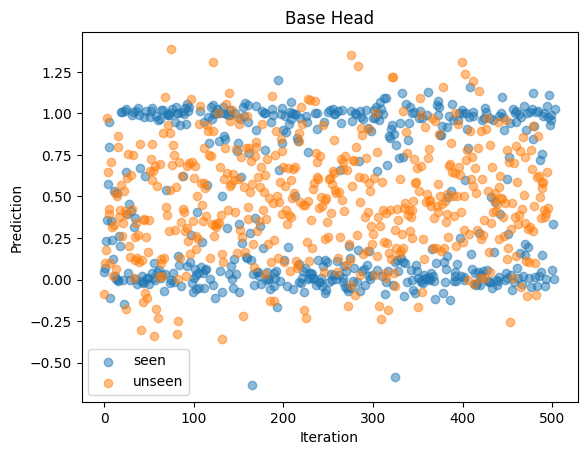

In [46]:
plt.scatter(np.arange(len(seen_logits)), seen_logits, alpha=0.5, label='seen')
plt.scatter(np.arange(len(unseen_logits)), unseen_logits, alpha=0.5, label='unseen')
plt.legend()
plt.title("Base Head")
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.show()

In [47]:
# Separate seen and unseen for plotting
seen_meta_pred = []
unseen_meta_pred = []
for label, pred in zip(labels_true, meta_logits_pred):
    if label:
        seen_meta_pred.append(pred)
    else:
        unseen_meta_pred.append(pred)

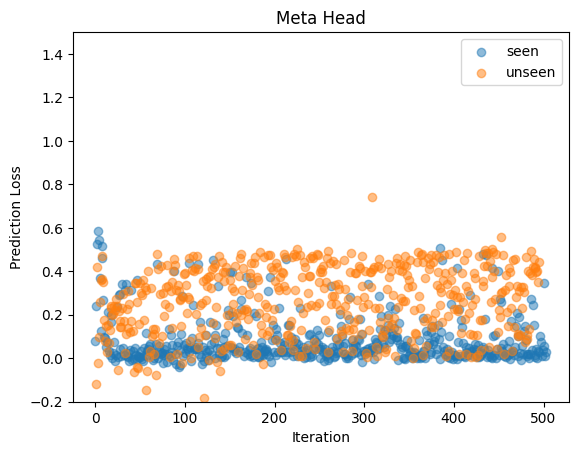

In [48]:
plt.scatter(np.arange(len(seen_meta_pred)), seen_meta_pred, alpha=0.5, label='seen')
plt.scatter(np.arange(len(unseen_meta_pred)), unseen_meta_pred, alpha=0.5, label='unseen')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Prediction Loss")
plt.title("Meta Head")
plt.ylim(-.2, 1.5)
plt.show()